CSI 4106 - A2

Simon Paquette

300044038

spaqu044@uottawa.ca


In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs


from pathlib import Path
import time
from sklearn.utils.class_weight import compute_class_weight

Reusing TensorBoard on port 6006 (pid 5064), started 7:29:21 ago. (Use '!kill 5064' to kill it.)

#### Loading the relevant datasets (15/100)


Train shape: (15026, 4)
Val shape: (3757, 4)
Test shape: (4696, 4)
Index(['age', 'ethnicity', 'gender', 'img_name'], dtype='object')
   age  ethnicity  gender                        img_name
0   57          0       0  20170120222949154.jpg.chip.jpg
1   42          0       1  20170116221807908.jpg.chip.jpg
2   57          0       0  20170104212808228.jpg.chip.jpg
3   25          0       0  20170117192955499.jpg.chip.jpg
4   46          3       0  20170119201157876.jpg.chip.jpg
Train gender:
 0    52.335951
1    47.664049
Name: gender, dtype: float64
Val gender:
 0    52.302369
1    47.697631
Name: gender, dtype: float64
Test gender:
 0    52.29983
1    47.70017
Name: gender, dtype: float64
Train ethnicity:
 0    42.406495
1    19.093571
3    16.797551
2    14.548117
4     7.154266
Name: ethnicity, dtype: float64
Val ethnicity:
 0    42.400852
1    19.084376
3    16.821932
2    14.559489
4     7.133351
Name: ethnicity, dtype: float64
Test ethnicity:
 0    42.397785
1    19.080068
3    16

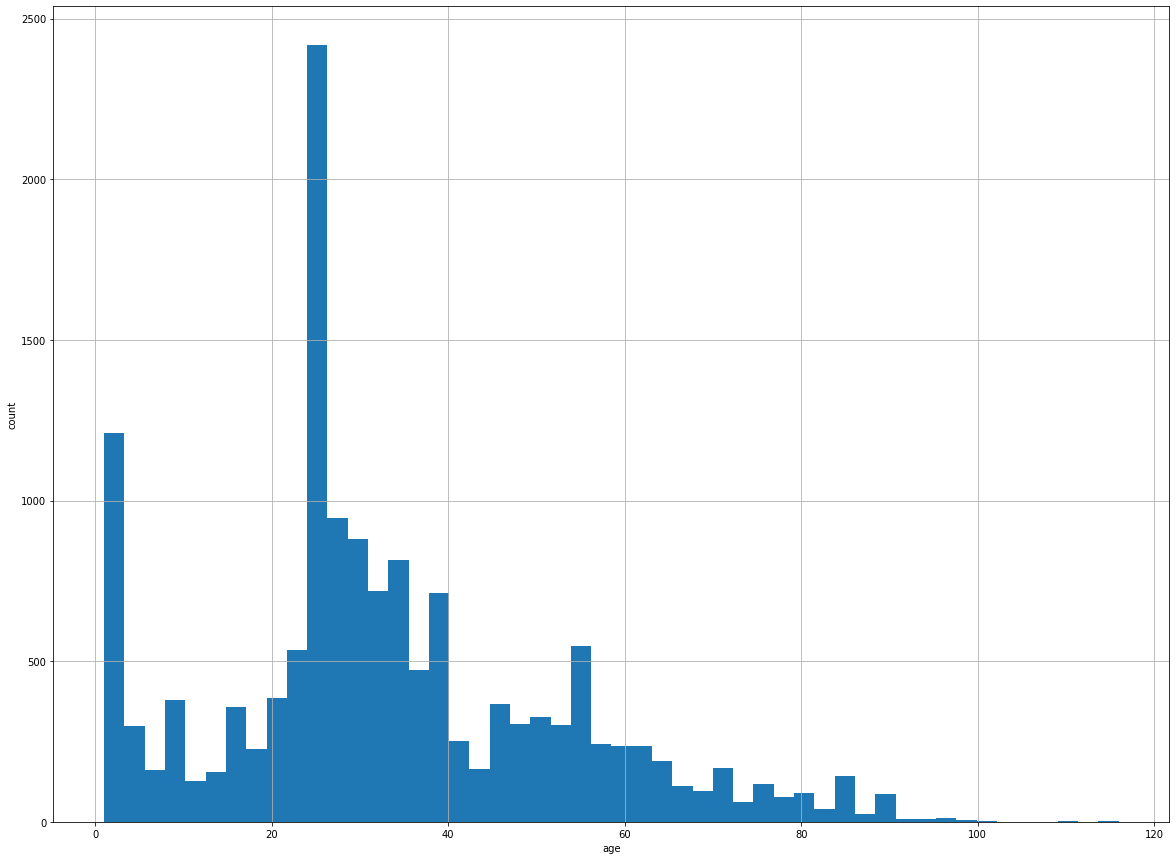

In [2]:
# load the datasets using the csv files train, val and test
# (3)
train_path_csv = Path("data/train.csv")
val_path_csv = Path("data/val.csv")
test_path_csv = Path("data/test.csv")

train_df = pd.read_csv(train_path_csv)
val_df = pd.read_csv(val_path_csv)
test_df = pd.read_csv(test_path_csv)

# print the shapes of the dataframes
# (3)
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)
print("Test shape:", test_df.shape)

# print the column names from either one of the dataframes
# (1)
print(train_df.columns)
print(train_df.head())  # NOTE: added for me to visualize

# print the proportional distribution of gender in all three datasets(i.e., number of male and female)
# (3)
print("Train gender:\n", train_df["gender"].value_counts(normalize=True) * 100)
print("Val gender:\n", val_df["gender"].value_counts(normalize=True) * 100)
print("Test gender:\n", test_df["gender"].value_counts(normalize=True) * 100)

# print the proportional distribution of ethnicity in all three datasets
# (3)
print("Train ethnicity:\n", train_df["ethnicity"].value_counts(normalize=True) * 100)
print("Val ethnicity:\n", val_df["ethnicity"].value_counts(normalize=True) * 100)
print("Test ethnicity:\n", test_df["ethnicity"].value_counts(normalize=True) * 100)

# NOTE: HERE, the ethnicity is imbalanced, i will use class weight later on

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are:
# (2)
age_df = train_df["age"]
age_df.hist(bins=50, figsize=(20, 15))
plt.xlabel("age")
plt.ylabel("count")
plt.show()


#### Create the ImageDataGenerators (22/100)


Found 15026 validated image filenames.
Found 4696 validated image filenames.
Found 3757 validated image filenames.


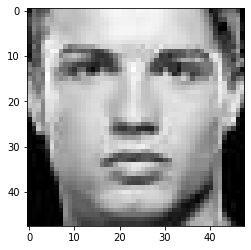

In [3]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 32
HEIGHT = 48
WIDTH = 48
SIZE = (HEIGHT, WIDTH)

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
train_generator = train_img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory="data/images/train",
    x_col="img_name",
    y_col=["age", "ethnicity", "gender"],
    target_size=SIZE,
    color_mode="grayscale",
    class_mode="multi_output",
    batch_size=batch_size,
    shuffle=True,
    seed=SEED,
)


# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of th eaugmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
    rescale=1.0 / 255,
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
# NOTE: i assume here its for test dataset ??
test_generator = val_img_gen.flow_from_dataframe(
    dataframe=test_df,
    directory="data/images/test",
    x_col="img_name",
    y_col=["age", "ethnicity", "gender"],
    target_size=SIZE,
    color_mode="grayscale",
    class_mode="multi_output",
    batch_size=batch_size,
    shuffle=False,
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
# NOTE: i assume here its for validation dataset ??
val_generator = val_img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory="data/images/val",
    x_col="img_name",
    y_col=["age", "ethnicity", "gender"],
    target_size=SIZE,
    color_mode="grayscale",
    class_mode="multi_output",
    batch_size=batch_size,
    shuffle=False,
)


# enumerate through the validation data generator created above and plot first grayscale image
# (2)
for i, element in enumerate(val_generator):
    features, labels = element
    image = features[1:2]
    image = np.resize(image, SIZE)
    plt.imshow(image, cmap="gray")
    plt.plot()
    break


#### Create the model (44/100)


In [4]:
# specify the model input with the required shape
# (1)
input_layer = layers.Input((HEIGHT, WIDTH, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# (10)
shared_layer = layers.Conv2D(
    64, (5, 5), activation="relu", padding="same", name="IN_SHARED"
)(input_layer)
shared_layer = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(
    shared_layer
)
shared_layer = layers.MaxPooling2D(2, 2)(shared_layer)
shared_layer = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(
    shared_layer
)
shared_layer = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(
    shared_layer
)
shared_layer = layers.MaxPooling2D(2, 2)(shared_layer)
shared_layer = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(
    shared_layer
)
shared_layer = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(
    shared_layer
)
shared_layer = layers.MaxPooling2D(2, 2)(shared_layer)
shared_layer = layers.Flatten(name="OUT_SHARED_FLATTEN")(shared_layer)

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# (2)
age_layer = layers.Dense(256, activation="relu", name="IN_AGE")(shared_layer)
age_layer = layers.Dense(128, activation="relu")(age_layer)
age_layer = layers.Dense(64, activation="relu")(age_layer)

# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task
# (2)
age_layer = layers.Dense(1, activation="linear", name="OUT_AGE_LINEAR")(age_layer)

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
# (2)
ethnicity_layer = layers.Dense(256, activation="relu", name="IN_ETHNICITY")(
    shared_layer
)
ethnicity_layer = layers.Dense(128, activation="relu")(ethnicity_layer)
ethnicity_layer = layers.Dense(64, activation="relu")(ethnicity_layer)
# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
# (2)
ethnicity_layer = layers.Dense(5, activation="softmax", name="OUT_ETHNICITY_SOFTMAX")(
    ethnicity_layer
)

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
# (2)
gender_layer = layers.Dense(128, activation="relu", name="IN_GENDER")(shared_layer)
gender_layer = layers.Dropout(0.2)(gender_layer)
gender_layer = layers.Dense(64, activation="relu")(gender_layer)
# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task
# (2)
gender_layer = layers.Dense(1, activation="sigmoid", name="OUT_GENDER_SIGMOID")(
    gender_layer
)

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# (3)
model = keras.Model(
    inputs=input_layer, outputs=[age_layer, ethnicity_layer, gender_layer]
)

# print the model summary
# (0.5)
model.summary()

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# (2)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

# specify the losses to be used for each task: age, ethnicity and gender prediction
# (0.5)
losses = {
    "OUT_AGE_LINEAR": keras.losses.MeanSquaredError(),
    "OUT_ETHNICITY_SOFTMAX": keras.losses.SparseCategoricalCrossentropy(),
    "OUT_GENDER_SIGMOID": keras.losses.BinaryCrossentropy(),
}

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
loss_weights = [0.001, 0.5, 0.5]

# please remember to use the relevant metric for each task by assigning it to the correct output
metrics = {
    "OUT_AGE_LINEAR": keras.metrics.MeanAbsoluteError(name="MAE_AGE"),
    "OUT_ETHNICITY_SOFTMAX": keras.metrics.SparseCategoricalAccuracy(
        name="ACC_ETHNICITY"
    ),
    "OUT_GENDER_SIGMOID": keras.metrics.BinaryAccuracy(name="ACC_GENDER"),
}

# (2)
model.compile(
    optimizer=optimizer, loss=losses, metrics=metrics, loss_weights=loss_weights
)


# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True, verbose=1
)
# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)
TMP_DIR = Path("models")
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    TMP_DIR.joinpath(str(int(time.time()))),
    verbose=1,
    monitor="val_loss",
    save_best_only=True,
)
# Initiallize TensorBoard
# (2)
LOGS_DIR = Path("logs")
tensorboard = tf.keras.callbacks.TensorBoard(LOGS_DIR.joinpath(str(int(time.time()))))
# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# (2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=2, verbose=1, factor=0.1, monitor="val_loss", min_lr=0.000001
)
# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)
CALLBACKS = [early_stop, checkpoints, tensorboard, reduce_lr]


# NOTE: ADDED TO VISUALIZE SCHEMA FOR ME
img_file = "./model_arch.png"
tf.keras.utils.plot_model(
    model, to_file=img_file, show_shapes=True, show_layer_names=True
)


# NOTE: trying to balance ethnicity data
y_train = train_df["ethnicity"].to_numpy()
ethnicity_class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)

class_weights = {
    "OUT_AGE_LINEAR": None,
    "OUT_ETHNICITY_SOFTMAX": dict(enumerate(ethnicity_class_weights)),
    "OUT_GENDER_SIGMOID": None,
}
print("Class weights:", class_weights)

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # will stop before because of the callback 'early stop'
    batch_size=batch_size,
    callbacks=CALLBACKS,
    steps_per_epoch=len(train_df) / batch_size,
    validation_steps=len(val_df) / batch_size,
    # NOTE: does not seem to work with multi-ouput for TF28
    #class_weight=class_weights,
)

# NOTE: keep model to save time
model.save("models/test_ethnic")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 IN_SHARED (Conv2D)             (None, 48, 48, 64)   1664        ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   102464      ['IN_SHARED[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 64)   0           ['conv2d[0][0]']                 
                                                                                              

#### Making predictions on test data (14/100)


In [5]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
# (4)
(
    loss,
    age_loss,
    ethnicity_loss,
    gender_loss,
    age_mae,
    ethnicity_acc,
    gender_acc,
) = model.evaluate(test_generator)

print("Ethnicity accuracy:", ethnicity_acc)
print("Gender accuracy:", gender_acc)


147/147 [==============================] - 19s 129ms/step - loss: 0.6143 - OUT_AGE_LINEAR_loss: 109.4439 - OUT_ETHNICITY_SOFTMAX_loss: 0.7325 - OUT_GENDER_SIGMOID_loss: 0.2773 - OUT_AGE_LINEAR_MAE_AGE: 7.5364 - OUT_ETHNICITY_SOFTMAX_ACC_ETHNICITY: 0.7419 - OUT_GENDER_SIGMOID_ACC_GENDER: 0.8829
Ethnicity accuracy: 0.7419080138206482
Gender accuracy: 0.8828790187835693


In [6]:
# generate predictions using the test generator
# (2)
predictions = model.predict(test_generator)

# extract the ethnicity predictions
# (2)
age, ethnicity, gender = predictions
ethnicity = np.array([np.argmax(x) for x in ethnicity])
# print the classification report for predicting ethnicity
# (2)
y_true = test_df["ethnicity"].to_numpy()
classif = classification_report(y_true, ethnicity)
print("ethnicity:\n", classif)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
# (2)
gender = [x[0] for x in gender.tolist()]
for index, g in enumerate(gender):
    if g > 0.5:
        gender[index] = 1
    else:
        gender[index] = 0
# print the classification report for predicting gender
# (2)
y_true = test_df["gender"].to_numpy()
classif = classification_report(y_true, gender)
print("Gender:\n", classif)


# NOTE: simply for me, age
age = [x[0] for x in age.tolist()]


ethnicity:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81      1991
           1       0.77      0.83      0.80       896
           2       0.72      0.79      0.76       683
           3       0.66      0.65      0.66       790
           4       0.34      0.16      0.22       336

    accuracy                           0.74      4696
   macro avg       0.66      0.65      0.65      4696
weighted avg       0.73      0.74      0.73      4696

Gender:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2456
           1       0.90      0.85      0.87      2240

    accuracy                           0.88      4696
   macro avg       0.88      0.88      0.88      4696
weighted avg       0.88      0.88      0.88      4696



#### Present prediction results on test data(5/100)


Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields

- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
  Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters                                               | Age(MAE) test | Ethnicity(Accuracy) test | Gender(Accuracy) test |
| ------------------------------------------------------------- | ------------- | ------------------------ | --------------------- |
| initial setup: batch16, rmsprop, lr=0.001, plateau_lr=0.00001 | 7.347         | 68.75                    | 87.50                 |
| batch32 (better)                                              | 7.599         | 74.23                    | 87.54                 |
| batch64                                                       | 8.537         | 72.08                    | 86.67                 |
| optimizer=Adam                                                | 9.671         | 65.20                    | 82.82                 |
| lr=0.01                                                       | 16.85         | 43.75                    | 40.62                 |
| lr=0.0001 (slow)                                              | 7.307         | 76.32                    | 88.46                 |
| plateau_lr=0.000001 (better)                                  | 7.140         | 76.30                    | 88.14                 |

So, I choose: batch=32, optimizer=RMSPROP, lr=0.001, plateau_lr=0.000001

For the creation of the layers in the model, i did different tests (looking with tensorboard), but did not record the accuracy to show my result of this model architecture (as you can see with model_arch.png).

In the shared layer, i tried different number of maxPooling and conv2d and the number of filter. I decided to do (2conv+1pool)\*3 when increasing gradually the number of filters was the best result. Doing 1conv was underfitting and doing 3conv produce approximately the same result but with longer calculation time. Batch normalization was not necessarly because i did not overfit.

In the specific layers, I decided to apply 3 dense layer with decreasing units (256-128-64) for age and ethnicity (no overfitting and no underfitting). For the gender, 3 layers was overfitting. So, I decided to reduce to 2 dense layer and 1 dropout of 0.2 in between.
